In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "../DatasetGFT"
ACTIVITY_LABELS = [0, 1, 2, 3, 4, 5]
ACTIVITY_NAMES = [
    "Rest",
    "Fold clothes",
    "Sweep",
    "Walk",
    "Move boxes",
    "Bike"
]

SAMPLING_RATE = 50
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2
TRIM_SECONDS = 5
TRIM_SAMPLES = TRIM_SECONDS * SAMPLING_RATE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_enu", "ay_enu", "az_enu", "gx_enu", "gy_enu", "gz_enu"]

In [7]:
#This function just find each contiguous section of labels, and trims 5 secs from start and end to remove transition buffers
def trim_activity_segments(df, trim_samples=TRIM_SAMPLES):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    
    df['label_changed'] = df['label'].ne(df['label'].shift())
    df['segment_id'] = df['label_changed'].cumsum()
    
    segments_to_keep = []
    total_original = 0
    total_trimmed = 0
    
    for seg_id in df['segment_id'].unique():
        segment = df[df['segment_id'] == seg_id].copy()
        seg_len = len(segment)
        total_original += seg_len
        
        if seg_len > 2 * trim_samples:
            trimmed_segment = segment.iloc[trim_samples:-trim_samples]
            segments_to_keep.append(trimmed_segment)
            total_trimmed += len(trimmed_segment)
        else:
            print(f"  Skipping segment (label={segment['label'].iloc[0]}, length={seg_len} samples, {seg_len/SAMPLING_RATE:.1f}s) - too short after trimming")
    
    if segments_to_keep:
        df_trimmed = pd.concat(segments_to_keep, ignore_index=True)
        df_trimmed.drop(columns=['label_changed', 'segment_id'], inplace=True)
    else:
        df_trimmed = pd.DataFrame()
    
    print(f"  Trimmed {total_original - total_trimmed} / {total_original} samples ({100*(total_original - total_trimmed)/total_original:.1f}%)")
    print(f"  Kept {total_trimmed} samples across {len(segments_to_keep)} segments")
    
    return df_trimmed


def load_gft_csvs(base_dir):
    subject_dfs = {}
    for subject_id in sorted(os.listdir(base_dir)):
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue
        csv_files = glob.glob(
            os.path.join(subject_path, "IMU_GFT_*.csv")
        )
        if len(csv_files) == 0:
            continue
        df = pd.read_csv(csv_files[0])
        print(f"\nProcessing {subject_id}:")
        df = trim_activity_segments(df)
        if len(df) == 0:
            print(f"  Warning: No data left after trimming for {subject_id}")
            continue
        
        subject_dfs[subject_id] = df
    
    print(f"Successfully loaded {len(subject_dfs)} subjects")
    return subject_dfs
def split_subjects_60_20_20(subject_dfs):
    subjects = list(subject_dfs.keys())
    np.random.shuffle(subjects)
    
    n_total = len(subjects)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    
    train_subjects = subjects[:n_train]
    val_subjects = subjects[n_train:n_train + n_val]
    test_subjects = subjects[n_train + n_val:]
    
    print(f"\nDataset Split:")
    print(f"  Train subjects: {len(train_subjects)}")
    print(f"  Val subjects:   {len(val_subjects)}")
    print(f"  Test subjects:  {len(test_subjects)}")
    
    return (
        [subject_dfs[s] for s in train_subjects],
        [subject_dfs[s] for s in val_subjects],
        [subject_dfs[s] for s in test_subjects],
    )

In [3]:
def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]
def extract_features(window, cols):
    feats = []
    data = window[cols].values
    for i in range(len(cols)):
        x = data[:, i]
        
        mean_x = np.mean(x)
        std_x = np.std(x)
        feats.extend([
            mean_x,
            std_x,
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.mean(np.abs(x))
        ])
        
        fft_mag = np.abs(np.fft.rfft(x))
        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])
    
    return feats

def build_dataset(dfs, feature_cols):
    X, y = [], []
    
    for df in dfs:
        df = df[feature_cols + ["label"]]
        
        for w in sliding_windows(df):
            if w["label"].nunique() == 1:
                X.append(extract_features(w, feature_cols))
                y.append(w["label"].iloc[0])
    
    return np.array(X), np.array(y)

In [4]:
def zscore_normalize(X_train, X_val, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std    
    return X_train_norm, X_val_norm, X_test_norm

def balance_classes_undersample(X, y, random_state=42):
    np.random.seed(random_state)
    
    X_balanced = []
    y_balanced = []
    
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    print("\nClass distribution before balancing:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {int(c)} ({ACTIVITY_NAMES[int(c)]:15s}): {cnt:5d} samples")
    for cls in classes:
        idx = np.where(y == cls)[0]
        selected_idx = np.random.choice(idx, size=min_count, replace=False)
        
        X_balanced.append(X[selected_idx])
        y_balanced.append(y[selected_idx])
    
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.concatenate(y_balanced)
    
    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]
    
    print(f"\nBalanced to {min_count} samples per class")
    print(f"Total samples: {len(y_balanced)}")
    
    return X_balanced, y_balanced

In [5]:
def select_svm_on_validation(X_train, y_train, X_val, y_val):
    params = {
        "alpha": 0.0001,
    }
    
    svm = SGDClassifier(
        loss='hinge', 
        alpha=params["alpha"],
        max_iter=1000,
        tol=1e-3,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    print("\nTraining SVM with SGDClassifier...")
    svm.fit(X_train, y_train)
    
    y_val_pred = svm.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="macro")
    
    print(f"SVM parameters: {params}")
    print(f"Validation F1 (macro): {f1:.4f}")
    
    return svm, params

def evaluate_on_test(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    
    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred,
        target_names=ACTIVITY_NAMES,
        digits=4
    ))
    
    cm = confusion_matrix(y_test, y_pred, labels=ACTIVITY_LABELS)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=ACTIVITY_NAMES,
        yticklabels=ACTIVITY_NAMES,
        cmap="Blues",
        cbar_kws={'label': 'Count'}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro")
    }


Processing Subject01:
  Trimmed 4500 / 110740 samples (4.1%)
  Kept 106240 samples across 9 segments

Processing Subject02:
  Trimmed 4500 / 110563 samples (4.1%)
  Kept 106063 samples across 9 segments

Processing Subject03:
  Trimmed 4500 / 98902 samples (4.5%)
  Kept 94402 samples across 9 segments

Processing Subject04:
  Trimmed 4500 / 106672 samples (4.2%)
  Kept 102172 samples across 9 segments

Processing Subject05:
  Trimmed 4500 / 105411 samples (4.3%)
  Kept 100911 samples across 9 segments

Processing Subject06:
  Trimmed 4500 / 103438 samples (4.4%)
  Kept 98938 samples across 9 segments

Processing Subject07:
  Trimmed 4500 / 108957 samples (4.1%)
  Kept 104457 samples across 9 segments

Processing Subject08:
  Trimmed 4500 / 105612 samples (4.3%)
  Kept 101112 samples across 9 segments

Processing Subject09:
  Trimmed 4500 / 102335 samples (4.4%)
  Kept 97835 samples across 9 segments

Processing Subject10:
  Trimmed 4500 / 110796 samples (4.1%)
  Kept 106296 samples ac

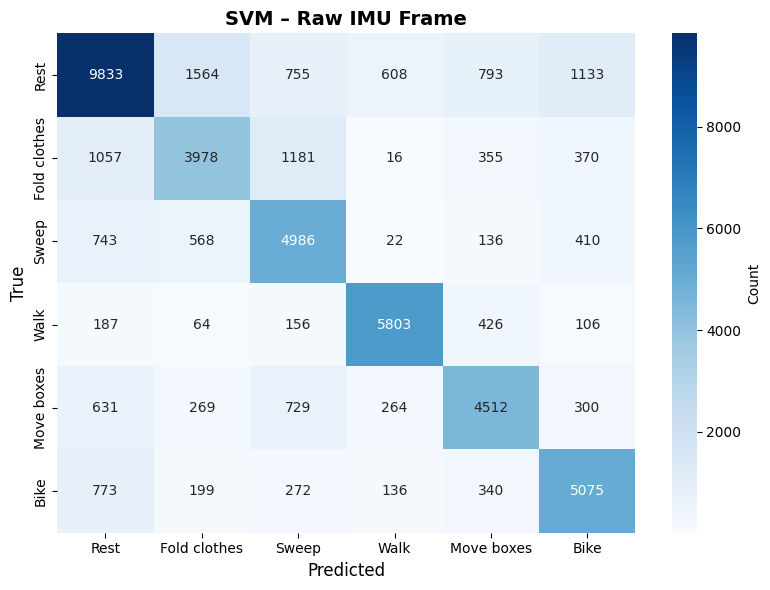


Dataset sizes (before balancing):
  Train: 147582 samples
  Val:   49476 samples
  Test:  48750 samples

Class distribution before balancing:
  Class 0 (Rest           ): 45435 samples
  Class 1 (Fold clothes   ): 21002 samples
  Class 2 (Sweep          ): 20452 samples
  Class 3 (Walk           ): 20488 samples
  Class 4 (Move boxes     ): 19978 samples
  Class 5 (Bike           ): 20227 samples

Balanced to 19978 samples per class
Total samples: 119868

Training SVM with SGDClassifier...
SVM parameters: {'alpha': 0.0001}
Validation F1 (macro): 0.6211

                  SVM – Global Frame (ENU)                  
              precision    recall  f1-score   support

        Rest     0.6891    0.7337    0.7107     14686
Fold clothes     0.5929    0.3307    0.4246      6957
       Sweep     0.5401    0.5027    0.5207      6865
        Walk     0.7009    0.8064    0.7500      6742
  Move boxes     0.6636    0.5873    0.6232      6705
        Bike     0.5023    0.6765    0.5766      6795

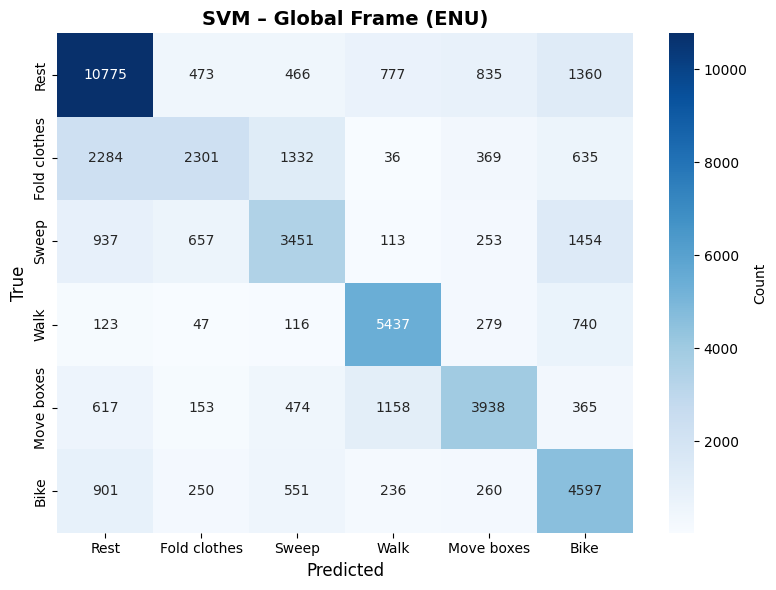

Summary

Raw IMU Frame:
  Precision: 0.6968
  Recall:    0.7080
  F1-Score:  0.7011

Global Frame (ENU):
  Precision: 0.6148
  Recall:    0.6062
  F1-Score:  0.6010


In [8]:
if __name__ == "__main__":
    subject_dfs = load_gft_csvs(DATA_DIR)
    train_dfs, val_dfs, test_dfs = split_subjects_60_20_20(subject_dfs)
    X_train_raw, y_train_raw = build_dataset(train_dfs, RAW_FEATURES)
    X_val_raw, y_val_raw = build_dataset(val_dfs, RAW_FEATURES)
    X_test_raw, y_test_raw = build_dataset(test_dfs, RAW_FEATURES)
    
    print(f"\nDataset sizes (before balancing):")
    print(f"  Train: {len(X_train_raw)} samples")
    print(f"  Val:   {len(X_val_raw)} samples")
    print(f"  Test:  {len(X_test_raw)} samples")
    
    X_train_raw, y_train_raw = balance_classes_undersample(
        X_train_raw, y_train_raw, random_state=RANDOM_STATE
    )
    X_train_raw, X_val_raw, X_test_raw = zscore_normalize(
        X_train_raw, X_val_raw, X_test_raw
    )
    raw_model, raw_params = select_svm_on_validation(
        X_train_raw, y_train_raw,
        X_val_raw, y_val_raw
    )
    raw_metrics = evaluate_on_test(
        raw_model,
        X_test_raw, y_test_raw,
        "SVM – Raw IMU Frame"
    )
    
    X_train_gft, y_train_gft = build_dataset(train_dfs, GFT_FEATURES)
    X_val_gft, y_val_gft = build_dataset(val_dfs, GFT_FEATURES)
    X_test_gft, y_test_gft = build_dataset(test_dfs, GFT_FEATURES)
    
    print(f"\nDataset sizes (before balancing):")
    print(f"  Train: {len(X_train_gft)} samples")
    print(f"  Val:   {len(X_val_gft)} samples")
    print(f"  Test:  {len(X_test_gft)} samples")
    
    X_train_gft, y_train_gft = balance_classes_undersample(
        X_train_gft, y_train_gft, random_state=RANDOM_STATE
    )
    X_train_gft, X_val_gft, X_test_gft = zscore_normalize(
        X_train_gft, X_val_gft, X_test_gft
    )
    gft_model, gft_params = select_svm_on_validation(
        X_train_gft, y_train_gft,
        X_val_gft, y_val_gft
    )
    gft_metrics = evaluate_on_test(
        gft_model,
        X_test_gft, y_test_gft,
        "SVM – Global Frame (ENU)"
    )
    
    print("Summary")
    print(f"\nRaw IMU Frame:")
    print(f"  Precision: {raw_metrics['precision']:.4f}")
    print(f"  Recall:    {raw_metrics['recall']:.4f}")
    print(f"  F1-Score:  {raw_metrics['f1']:.4f}")
    
    print(f"\nGlobal Frame (ENU):")
    print(f"  Precision: {gft_metrics['precision']:.4f}")
    print(f"  Recall:    {gft_metrics['recall']:.4f}")
    print(f"  F1-Score:  {gft_metrics['f1']:.4f}")